## Read MRI Brain Volume

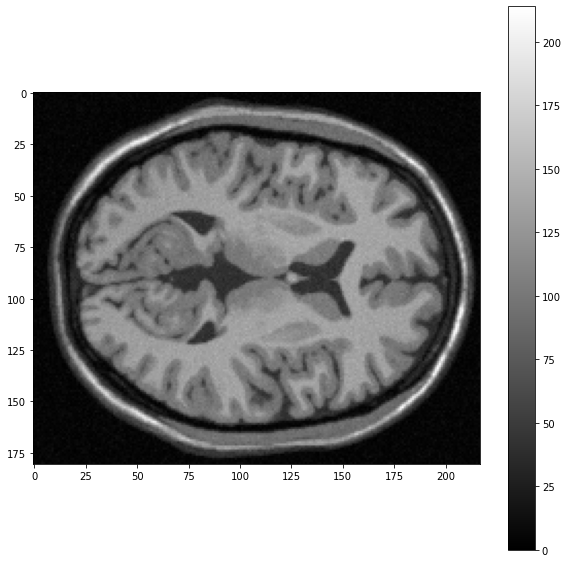

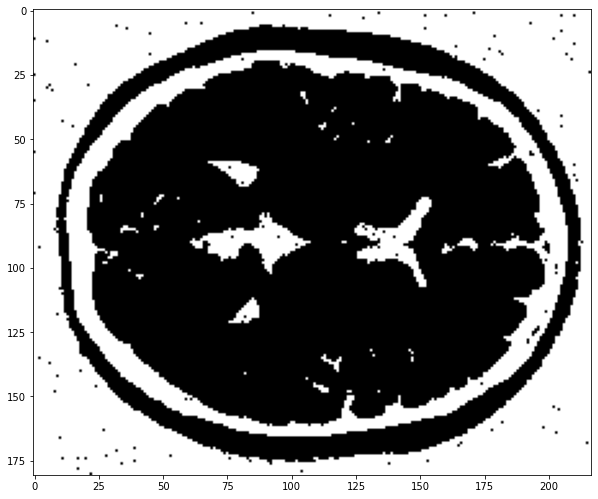

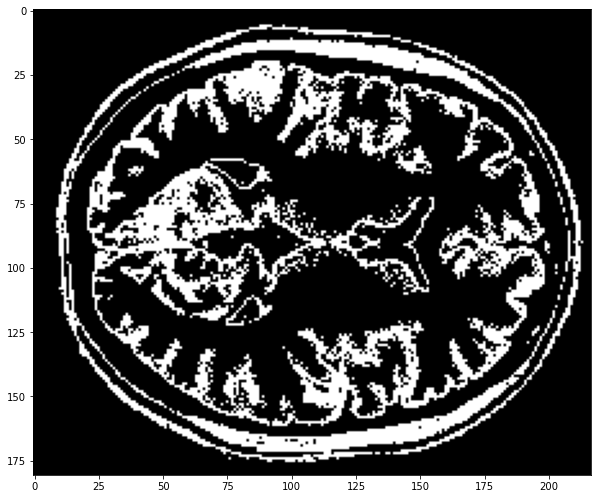

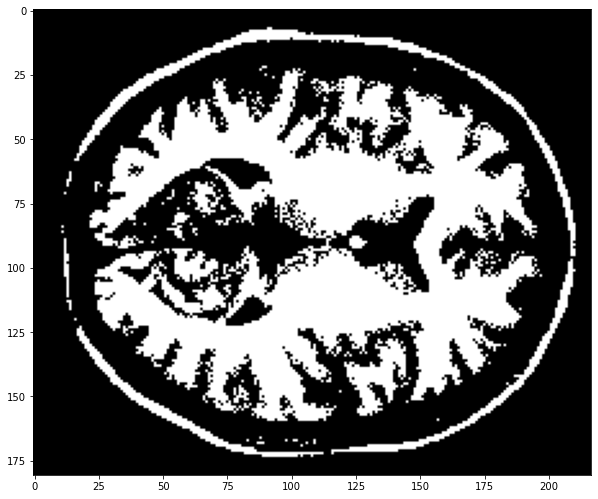

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks

Image_raw = np.fromfile("t1_icbm_normal_1mm_pn3_rf20.rawb",  dtype=np.uint8)
Image = np.reshape(Image_raw,(181,217,181),order='F') # hard coded dimensions


img = Image[:,:,80]

threshold1 = 50

threshold2 = 100



plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(np.logical_and(img>0, img<threshold1), cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(np.logical_and(img>threshold1, img<threshold2), cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(np.logical_and(img>threshold2, img<256), cmap='gray')







## Generate and Visualize Histogram of Values in the 3D Image

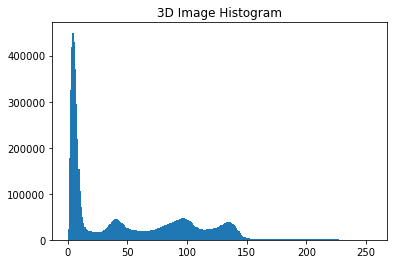

In [2]:
H = plt.hist(Image.flatten(), bins=255)
plt.title("3D Image Histogram")
plt.show()

#print(H[0])

## Gaussian Mixture Model

Manually implement the expectation maximization algorithm with gaussian mixture models to identify clusters in the dataset

Ref: 
Pattern Recognition and Machine Learning (Information Science and Statistics)
by Christopher M. Bishop 

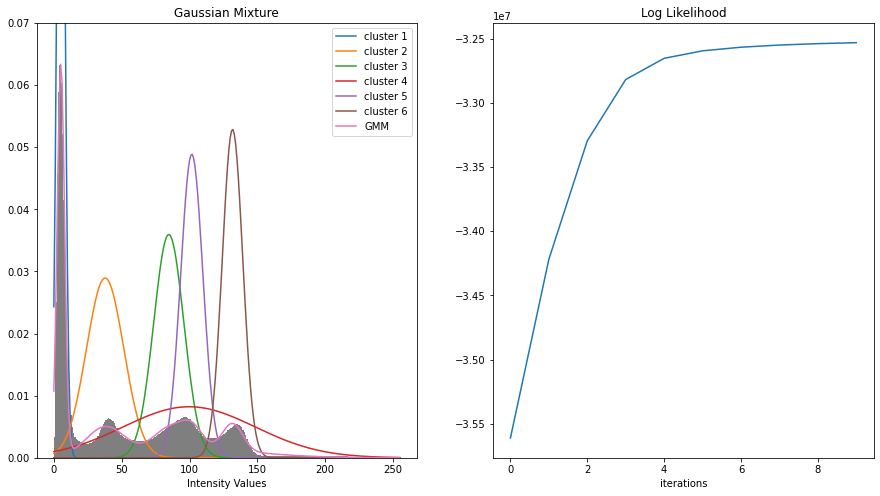

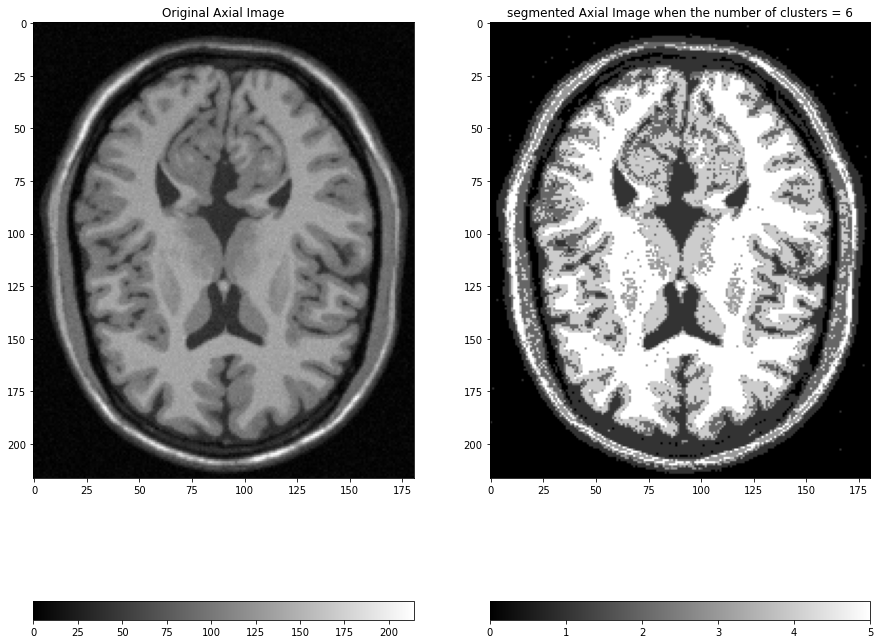

In [5]:
%matplotlib inline
from scipy.stats import norm
from IPython import display
import time


def initialize_cluster_param(hist,bins,num_clust):
    
    
    # get the peaks in the hostogram
    peaks, prop = find_peaks(hist, height=0)
    mu = np.sort(peaks[np.argsort(prop['peak_heights'])[-1:-(num_clust+1):-1]])
    
    # set initial variance
    variance = [((bins[-1]- 0)/num_clust)**1 for i in range(num_clust)]
    
    
    # assing same probability (sum up to one) while we don't have 
    # any information on the prior probabilty of each cluster
    cluster_prior = [1/num_clust for i in range(num_clust)]
    
    
    return mu, variance, cluster_prior



def plot_Guass_Curves(H, mu,variance,cluster_prior):
    
    
    # Plots the histogram along with the cluster and micture Gaussian distributions
    # Inputs:
    #      H: previously estimated image histogram
    #      mu: claster means (1D array)
    #      variance: cluster variances (1D array)
    #      cluster_prior: cluster prior probabilities (1D array)
    # Retuen:
    #       None
    
    
    
    #print(mu,variance)
    
    mixture = np.zeros(np.shape(H[1]))
    # plot individual Guassian and update mixture
    for i in range(len(mu)):
        
        plt.plot(H[1],norm.pdf(H[1], loc=mu[i],scale=np.sqrt(variance[i])),label=f'cluster {i+1}')
        plt.legend()
        mixture += cluster_prior[i]*norm.pdf(H[1], loc=mu[i],scale=np.sqrt(variance[i]))
    
    #plot mixture
    
    plt.plot(H[1],mixture,label=f'GMM')
    plt.legend()
    
    # plot image histogram
    counts = H[0]
    bins = H[1]
    plt.hist(bins[:-1], bins, weights=counts, density='True')
    plt.ylim(0,0.07)
    
    plt.title('Gaussian Mixture')
    plt.xlabel('Intensity Values')
    
    
    #plt.show()
    
    
                
def Expectation(Image, mu,variance,cluster_prior):
    
    # Estimates the class membership probabilites for each image voxel
    # Inputs:
    #      Image: 3D MRI volume m x n x k (3D array)
    #      mu: claster means (1D array)
    #      variance: cluster variances (1D array)
    #      cluster_prior: cluster prior probabilities (1D array)
    #
    # Return:
    #       member: cluster responsibilites (membership probabilities) per voxel m x n x k x numb_clusters
    #               (4D array)
    
    
    
    num_clusters = np.size(mu)
    member = np.zeros((np.shape(Image)[0],np.shape(Image)[1],np.shape(Image)[2],num_clusters))
    normalizing = np.zeros(np.shape(Image))
    
    # calculate unnormalized cluster responsibilities per voxel
    
    for i in range(num_clusters):
        
        norm_dist = norm.pdf(Image, loc=mu[i],scale=np.sqrt(variance[i]))
        
        normalizing += cluster_prior[i]*norm_dist
        
        member[:,:,:,i] = cluster_prior[i]*norm_dist
    
    # normalize responsibilites
    for i in range(num_clusters):
        
        member[:,:,:,i] /= normalizing
    
    
    return member

def Maximization(Image, gamma):
    
    
    # Updates the class mean, variance and prior probability according to the latest class membership
    # Inputs:
    #      Image: 3D MRI volume m x n x k (numpy 3D array)
    #      gamma: cluster responsibilites (membership probabilities) per voxel m x n x k x numb_clusters
    #      (numpy 4D array)
    #
    # Return:
    #       
    #      mu: updated claster means (1D array)
    #      variance: updated cluster variances (1D array)
    #      cluster_prior: updated cluster prior probabilities (1D array)
    
    
    total_pixels = np.size(Image)
    
    num_clusters = np.shape(gamma)[-1]
    
    N_k = np.zeros(num_clusters)
    mu = np.zeros(num_clusters)
    variance = np.zeros(num_clusters)
    cluster_prior = np.zeros(num_clusters)
    
    for i in range(num_clusters):
    
        N_k[i] = np.sum(gamma[:,:,:,i].flatten())
        
        temp_mu = gamma[:,:,:,i]*Image
        mu[i] = np.sum(temp_mu.flatten())/N_k[i]
        
        temp_var = gamma[:,:,:,i]*((Image - mu[i])**2)
        variance[i] = np.sum(temp_var.flatten())/N_k[i]
        
        cluster_prior[i] = N_k[i]/total_pixels
        
    sort_ind = np.argsort(mu)
        
    return mu[sort_ind], variance[sort_ind], cluster_prior[sort_ind]
    

def log_likelihood(mu,variance,cluster_prior):
    
    # Estimates the total log-likelihood for the image labeling
    # Inputs:
    #      Image: 3D MRI volume m x n x k (numpy 3D array)
    #      mu: claster means (1D array)
    #      variance: cluster variances (1D array)
    #      cluster_prior: cluster prior probabilities (1D array)
    #
    # Return:
    #        total log-likelihood (float)
    
    
    num_clusters = np.size(variance)
    
    likelihood = np.zeros(np.shape(Image))
    
    for i in range(num_clusters):
        
        likelihood += cluster_prior[i]*norm.pdf(Image, loc=mu[i],scale=np.sqrt(variance[i]))
        
    return np.sum(np.log(likelihood).flatten())
    
    

def GMM(Image,H,num_clusters):
    
    # Run the Gaussian Mixture Model on the image data
    
    # initilaize parameters that can affect the outcome
    mu,var,cluster_prior = initialize_cluster_param(H[0],H[1].astype(int),num_clusters)
    
    # visualize the initial Gaussian curves over the image histogram
    plot_Guass_Curves(H, mu,var,cluster_prior)
    display.clear_output(wait=True) 
    display.display(plt.gcf())
    #time.sleep(0.001)
    plt.close()

    count = 0
    
    iteration = []
    error = []
    gamma = []
    
    # setup initial values for the stopping criteria
    total_count = 10
    cost_old = log_likelihood(mu,var,cluster_prior)
    cost_diff = 1e16
    cost_diff_old = 1e16
    

    # include the number of iterations and total log-likelihood stopping citerion
   
    while count < total_count and cost_diff <= cost_diff_old:
       
        print(f'iteration: {count} Log Likelihood change: {cost_diff}')
        cost_diff_old = cost_diff
        #print(f'iteration {count} {cost_old} {cost_diff_old}')
        
        # Expectation- Maximization to calculate the class membership and 
        # update class parameters
        gamma = Expectation(Image, mu,var,cluster_prior)
        mu, var, cluster_prior = Maximization(Image, gamma)
        
        
        # display the updated Gaussian curves over the image histogram
        plt.figure(figsize=(15,8))  
        plt.subplot(1,2,1),plot_Guass_Curves(H, mu,var,cluster_prior)
        
        
        # Total log-likelihood estimation needed for the stopping criteria
        cost = log_likelihood(mu,var,cluster_prior)
        cost_diff = np.abs(cost - cost_old)
        cost_old = cost
        
        
        #display log-likelihood evolution
        
        error.append(cost)
        iteration.append(count)
        
        
        
        plt.subplot(1,2,2),plt.plot(iteration,error)
        plt.title('Log Likelihood')
        plt.xlabel('iterations')
        display.clear_output(wait=True) 
        display.display(plt.gcf())
        
        plt.close()
        
        count += 1
        
    return mu, var, cluster_prior, gamma


try :
    num_clusters = 6
    mu, var, cluster_prior, gamma = GMM(Image,H,num_clusters)

    # An exemplary image slice
    # results could vary from one slice to another

    #original image
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))    
    plt.subplot(1,2,1),plt.imshow(Image[:,:,80].T,cmap="gray")
    plt.colorbar( orientation='horizontal')
    plt.title('Original Axial Image')
    Image_labels1 = np.argmax(gamma,axis=3)
    # labeled image   
    plt.subplot(1,2,2),plt.imshow(Image_labels1[:,:,80].T,cmap="gray")
    plt.colorbar(ticks=list(range(num_clusters)), orientation='horizontal')
    plt.title(f'segmented Axial Image when the number of clusters = {num_clusters}')

except Exception as e:
    
    print(f'Error occured: {e}')

        
